In [1]:

import argparse
import os
import numpy as np
import pandas as pd
from nsd_access import NSDAccess
import scipy.io

from config import NSD_ROOT_DIR, DATA_ROOT_DIR
from tqdm import tqdm


subj = 'subj01'
atlasname = 'streams'

os.environ['http_proxy'] = 'http://127.0.0.1:7891'
os.environ['https_proxy'] = 'http://127.0.0.1:7891'

nsda = NSDAccess(NSD_ROOT_DIR)
nsd_expdesign = scipy.io.loadmat(os.path.join(NSD_ROOT_DIR, 'nsddata/experiments/nsd/nsd_expdesign.mat'))

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

size = 425
def calc(x, len, h, l, r):
    if (len <= 0):
        return 0
    l = h * l
    r = h * (1 - r)
    y = x + len
    return max(0, (min(y, r) - max(x, l)) / len)

def resize_bbox(bbox, cropBox, h, w):
    ratio = calc(bbox[0], bbox[2], w, cropBox[2], cropBox[3]) * calc(bbox[1], bbox[3], h, cropBox[0], cropBox[1])

    bbox[1] -= h * cropBox[0]
    h *= (1 - cropBox[0] - cropBox[1])

    bbox[0] -= w * cropBox[2]
    w = w * (1 - cropBox[2] - cropBox[3])

    bbox[0] *= size / w
    bbox[2] *= size / w

    bbox[1] *= size / h
    bbox[3] *= size / h

    # Boundary processing
    bbox[0] = max(0, bbox[0])
    bbox[1] = max(0, bbox[1])
    bbox[2] = min(size - bbox[0], bbox[2])
    bbox[3] = min(size - bbox[1], bbox[3])

    sratio = (bbox[2] * bbox[3]) / (size * size)

    return bbox, ratio, sratio


In [3]:

class_labels = [i for i in range(0, 200)]
for x in nsda.get_coco_cats_list():
    class_labels[x['id']] = x['name']

print(f"In total {len(class_labels)}")

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!
In total 200


In [4]:

st = 0
en = 73000

id_list = list(range(st, en))
info_list = nsda.get_image_info(id_list)
info_Img_list = nsda.read_image_coco_info_Img(id_list, info_type = 'instances')
annotations_list = nsda.read_image_coco_info(id_list, info_type='instances')


loading annotations into memory...
Done (t=15.78s)
creating index...
index created!
loading annotations into memory...
Done (t=0.56s)
creating index...
index created!
loading annotations into memory...
Done (t=14.45s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


In [7]:
n = 10
show = True
filter_ratio = 0.01

loading annotations into memory...
Done (t=0.46s)
creating index...
index created!


  0%|          | 0/10 [00:00<?, ?it/s]

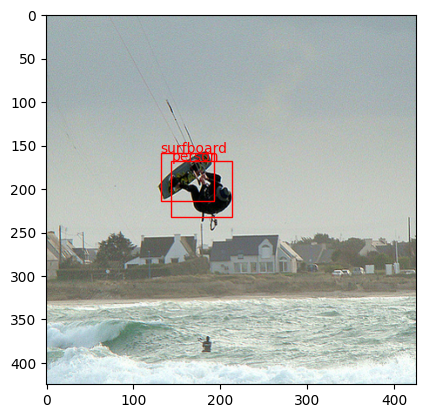

 10%|█         | 1/10 [00:00<00:02,  3.96it/s]

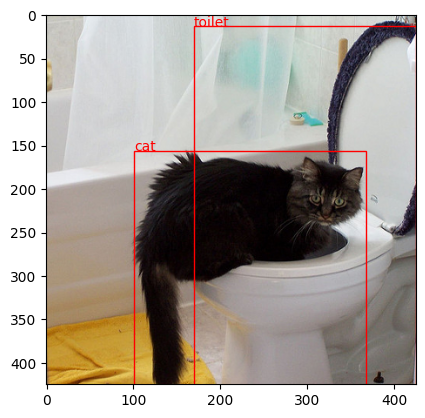

 20%|██        | 2/10 [00:00<00:01,  4.00it/s]

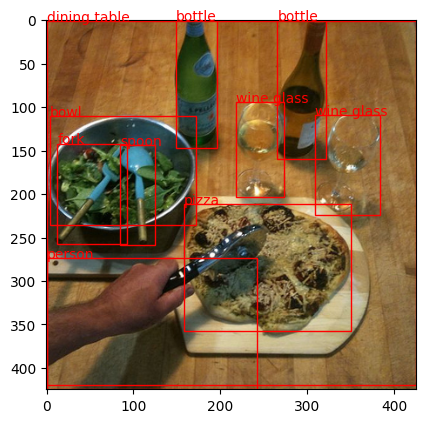

 30%|███       | 3/10 [00:00<00:01,  3.81it/s]

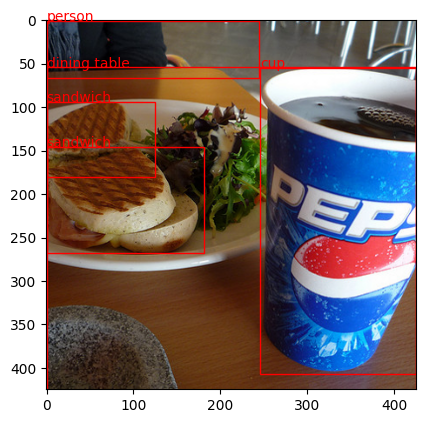

 40%|████      | 4/10 [00:01<00:01,  3.81it/s]

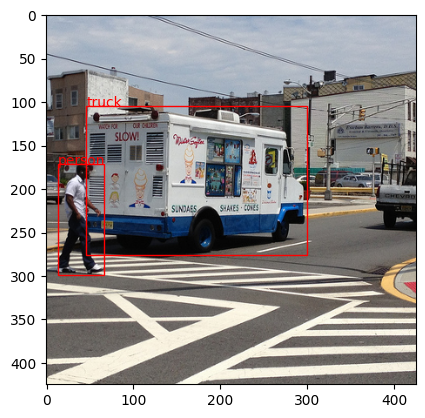

 50%|█████     | 5/10 [00:01<00:01,  3.93it/s]

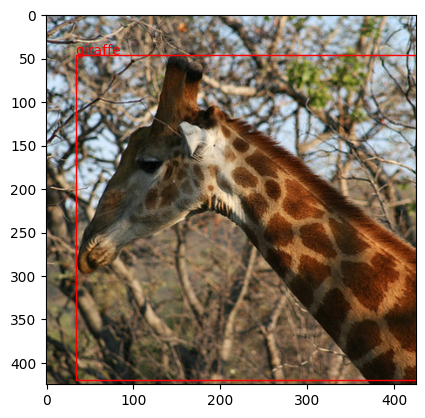

 60%|██████    | 6/10 [00:01<00:01,  3.99it/s]

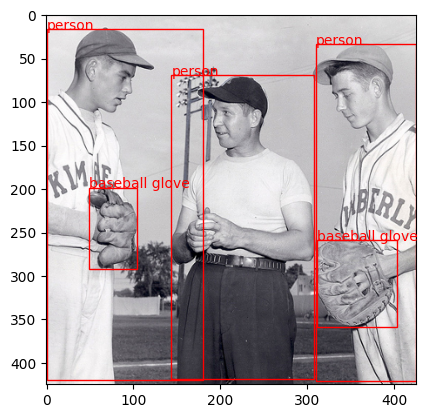

 70%|███████   | 7/10 [00:01<00:00,  3.99it/s]

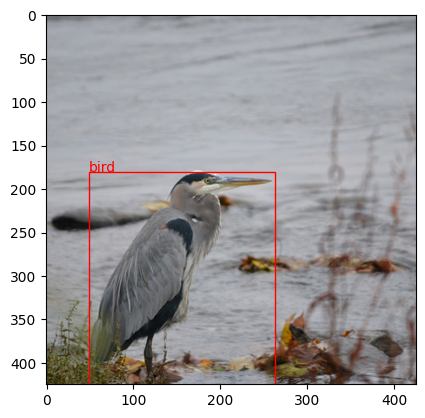

 80%|████████  | 8/10 [00:02<00:00,  4.03it/s]

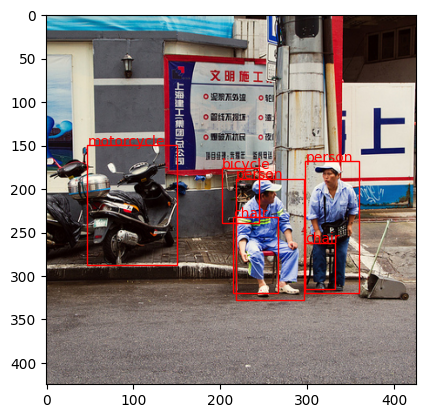

 90%|█████████ | 9/10 [00:02<00:00,  4.01it/s]

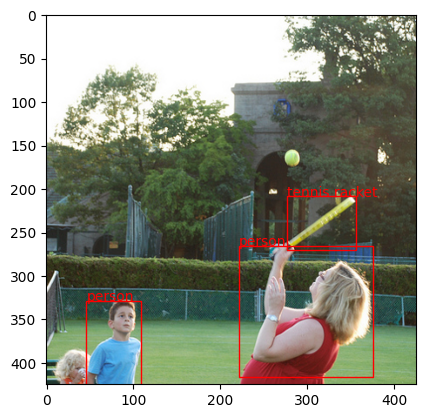

100%|██████████| 10/10 [00:02<00:00,  3.97it/s]


In [8]:
st = 0
en = st + n

id_list = id_list[st:en]
info_list = info_list[st:en]
info_Img_list = info_Img_list[st:en]
annotations_list = annotations_list[st:en]

outputs = nsda.get_coco_dataset().copy()
outputs['images'] = []
outputs['annotations'] = []
tot_annotation = 0


for i, (info, info_Img, annotations) in enumerate(tqdm(list(zip(info_list, info_Img_list, annotations_list)))):
    info_Img_new = info_Img[0].copy()
    info_Img_new['id'] = i
    info_Img_new['width'] = size
    info_Img_new['height'] = size
    info_Img_new['file_name'] = f'{i:06}.png'
    outputs['images'].append(info_Img_new)

    cropBox = info['cropBox']
    cropBox = eval(cropBox)
    h, w = info_Img[0]['height'], info_Img[0]['width']

    if (show):
        img = nsda.read_images(i, show=False)
        # Draw the image
        fig, ax = plt.subplots()
        ax.imshow(img)

    # Draw the annotations with class labels
    for annotation in annotations:
        # print(annotation)
        bbox = annotation['bbox'].copy()
        bbox, ratio, sratio = resize_bbox(bbox, cropBox, h, w)

        if ratio < 0.5:
            continue

        if sratio < filter_ratio:
            continue
        # print(sratio)

        annotation_new = annotation.copy()
        annotation_new['image_id'] = i
        annotation_new['bbox'] = bbox
        annotation_new['id'] = tot_annotation
        tot_annotation += 1
        outputs['annotations'].append(annotation_new)



        if (show):
            category_id = annotation['category_id']
            class_label = class_labels[category_id]  # Adjust index to match class_labels list
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.text(bbox[0], bbox[1], class_label, color='r')

    if (show):
        # Show the image with annotations
        plt.show()

import json

outputs_path = os.path.join(DATA_ROOT_DIR, f'instances_{st}_{en}_{filter_ratio}.json')
with open(outputs_path, "w") as f:
    json.dump(outputs, f)
    